Map MCS age onto global extreme rainfall percentiles

In [2]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
from skimage import measure
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
from datetime import datetime as dt
import pickle
from tqdm import tqdm

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

## current script object
thismodule = sys.modules[__name__]

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

Own modules available: ['casestudy', 'conditionalstats', 'conditionalstats_chunked', 'lifecycle_mapping', 'plot1D', 'plot2D', 'plotCondPDFs']
Own modules available: ['PrecipGrid', 'fcns_load_DYAMOND_SAM', 'fcns_load_RCEMIP_SAM', 'fcns_movie', 'fcns_multiscale_extremes', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND_modif_BF', 'fcns_load_DYAMOND_SAM_Tb_Feng', 'load_TOOCAN_v208_DYAMOND']


In [4]:
%autoreload 2

# to access segmentation files and simulation outputs
from fcns_load_DYAMOND_SAM import *
# to access TOOCAN objects
# from load_TOOCAN_DYAMOND_modif_BF import *
from load_TOOCAN_v208_DYAMOND import *
# mapping function
from lifecycle_mapping import *
# display functions
from fcns_movie import *
# plotting
from plot1D import *

In [5]:
# load relation table
relation_table = loadRelTable('DYAMOND_SEG')

In [6]:
glob.glob(os.path.join(DIR_TOOCAN_DYAMOND,'*.gz'))

['/bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz',
 '/bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz']

In [7]:
toocan = loadAllMCSs(DIR_TOOCAN_DYAMOND,load_TOOCAN_DYAMOND)

load /bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz
load /bdd/MT_WORKSPACE/lgouttes/MODELS/DYAMOND/Summer/SAM/235K/TOOCAN/TOOCAN_v2.08/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz


In [8]:
toocan_version = 'v2.08'
toocan_version_str = toocan_version.replace('.','')

if toocan_version == 'v2.07':
    label_key = 'label'
    duration_key = 'duration'
    area_key = 'surfkm2_172Wm2'
    utime_init_key = 'Utime_Init'
    utime_end_key = 'Utime_End'
elif toocan_version == 'v2.08':
    label_key = 'DCS_number'
    duration_key = 'INT_duration'
    area_key = 'LC_surfkm2_241K'
    utime_init_key = 'INT_UTC_timeInit'
    utime_end_key = 'INT_UTC_timeEnd'

In [9]:
# list of TOOCAN labels, for quicker mapping on toocan list
labels_toocan = [getattr(toocan[i],label_key) for i in range(len(toocan))]

# Test LifeCycleMapping methods

In [14]:
# Example data

i_t = 500 # index in relation table
date = relation_table.loc[i_t].str_code

# load segmentation mask for that date
segmask = loadTOOCANSeg(i_t,relation_table)


In [15]:
# list all labels in segmask
def getLabelsInSegmentationMask(segmask):
    
    seg_1D = segmask.values.flatten()
    seg_1D_nonans = seg_1D[~np.isnan(seg_1D)]

    return np.unique(np.array(seg_1D_nonans,dtype=int))
    
labels_in_segmask = getLabelsInSegmentationMask(segmask)
print(labels_in_segmask)

[119749 121064 126715 ... 134180 134208 134331]


In [22]:
# set location on disk and check if exists
timetable_file = 'TOOCAN_time_table%s.csv'%toocan_version_str
timetable_path = os.path.join(DIR_DATA,timetable_file)

# check if table exists on disk
table_exists = len(glob.glob(timetable_path)) > 0 

# choose to overwrite
overwrite = False

# Load or compute time table

if table_exists and not overwrite:
    
    #-- read from disk
    print('reading from %s'%timetable_path)
    toocan_timetable = pd.read_csv(timetable_path)
    
else:
    
     toocan_timetable = None


In [17]:
lcm = LifeCycleMapping(None,relation_table,toocan_timetable,toocan)

## dev getMCSAge(self,i_t,MCS_label)

In [14]:
# example MCS label
label = 134180

# index in list
i_MCS = np.where(np.array(labels_toocan) == label)[0][0]

# print(i_MCS,lcm.toocan_index_of_label[label])

In [15]:
# show lifecycle

area_labels = 'surfkm2_172Wm2', 'surfkm2_132Wm2', 'surfkm2_110Wm2', 'surfkm2_90Wm2'
n_labs = len(area_labels)

fig,ax = plt.subplots(figsize=(6,5))

for i_l in range(n_labs):

    area_lab = area_labels[0]
    
    time = toocan[i_MCS].clusters.Localtime
    area_t = np.array(getattr(toocan[i_MCS].clusters,area_lab))
    
    ax.plot(time,area_t,label=area_lab)
    
plt.legend()

In [16]:
print(toocan[i_MCS].label)
bool(np.any(segmask == toocan[i_MCS].label).data)

134180


True

In [17]:
print(relation_table.loc[i_t].UTC)
print(relation_table.loc[i_t].str_code)
print(toocan[i_MCS].clusters.Utime == relation_table.loc[i_t].UTC)

17024.23
2016-8-11-11-30
[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


In [18]:
i_test = 500
time_i = toocan[i_test].Utime_Init
time_e = toocan[i_test].Utime_End
print('start_match =',toocan[i_test].clusters.Utime[0] == time_i)
print('end_match =',toocan[i_test].clusters.Utime[-1] == time_e)

start_match = True
end_match = True


In [19]:

def timeIndex2Timedelta(i_MCS,j_t_MCS):
    
    date_value = getattr(self.toocan[i_MCS].clusters,utime_key)[j_t_MCS]
                                   
        if toocan_version == 'v2.07':

            date_30mn = int((str(date_value).split('.')[-1]).ljust(2,'0')) #ljust
            # compute time delta
            td = dt.timedelta(days = int(date_value),seconds = date_30mn*30*60)
                                   
        elif toocan_version == 'v2.08': # check that is gives reasonable ages
                                   
            td = dt.timedelta(seconds=date_value) # in v2.08, stored value is seconds since 1970-01-01
        
    # return
    return td


def getAgeMCS(i_MCS,j_t_MCS):
    """Arguments:
    - i_MCS: index of MCS in toocan list
    - j_t_MCS: time index in MCS lifecycle
    
    Returns:
    - age in hours"""
    
    # birth time
    time_birth = timeIndex2Timedelta(i_MCS,0)
    # current time
    time_now = timeIndex2Timedelta(i_MCS,j_t_MCS)
    # age delta
    age_delta = time_now - time_birth
    
    return age_delta.total_seconds()/3600


In [20]:
# find correct slice in TOOCAN lifecycle for current time
j_MCS_at_t = np.where(getattr(toocan[i_MCS].clusters,utime_key) == relation_table.loc[i_t].UTC)[0][0]

# turn it into system's age
age = getAgeMCS(i_MCS,j_MCS_at_t) # in hours

# total lifetime
lifetime_MCS = getAgeMCS(i_MCS,-1) # in hours

age/lifetime_MCS

0.02857142857142857

In [21]:
# check if current label occurs in current segmentation mask
time_match = bool(np.any(segmask == getattr(toocan[i_MCS],label_key)).data)

if time_match:
    
    # find correct slice in TOOCAN lifecycle for current time
    j_MCS_at_t = np.where(getattr(toocan[i_MCS].clusters,utime_key) == relation_table.loc[i_t].UTC)[0][0]
    
    # turn it into system's age
    age_MCS_at_t = getAgeMCS(i_MCS,j_MCS_at_t) # in hours
    
    # total lifetime
    lifetime_MCS = getAgeMCS(i_MCS,-1) # in hours
    
    # normalized age
    norm_age_MCS_at_t = age_MCS_at_t/lifetime_MCS
    
    print('age:',age_MCS_at_t)
    print('duration:', lifetime_MCS)
    print('normalized age: %2.3f%%'%(norm_age_MCS_at_t*100))


age: 0.5
duration: 17.5
normalized age: 2.857%


## test getMCSAge(self,i_t,MCS_label)

In [22]:
lcm = LifeCycleMapping(None,relation_table,toocan_timetable,toocan)

In [23]:
# example time index
i_t_test = 500

# example MCS label
label_test = 134180

# load segmentation mask for that date
segmask = loadTOOCANSeg(i_t_test,relation_table)

In [24]:
age = lcm.computeMCSAgeMetrics(i_t_test,label_test,segmask)
print('age of MCS %d at time index %d:'%(label_test,i_t_test),age)

norm_age = lcm.computeMCSAgeMetrics(i_t_test,label_test,segmask,metric='norm_age')
print('Normalized age of MCS %d at time index %d:'%(label_test,i_t_test),norm_age)

age of MCS 134180 at time index 500: 0.5
Normalized age of MCS 134180 at time index 500: 0.02857142857142857


# dev segMaskToAgeMask

Speed up calculation of age mask by computing a time table first. Include it in __init__ function of class LifeCycleMapping.

In [44]:
#----- check conversion between datetime objects and utime values, in version v2.07 and v2.08 -----#

In [49]:
def utime2Datetime(Utime,toocan_version):
    """Convert Utime (as in TOOCAN objects) into datetime.datetime objects"""
    
    if toocan_version == 'v2.07':
        
        days = int(str(Utime).split('.')[0])
        n_steps = int(str(Utime).split('.')[1])
    
        date = np.datetime64(dt.datetime(1970,1,1) + dt.timedelta(seconds=days*86400+n_steps*30*60))
        
    elif toocan_version == 'v2.08':
        
        date = np.datetime64(dt.datetime(1970,1,1) + dt.timedelta(seconds=Utime))
    
    return date

In [46]:
utime_v207_in = relation_table.UTC[8]
date = Utime2Datetime(utime_v207_in,toocan_version='v2.07')
print(date)
delta_t = pd.to_datetime(date) - dt.datetime(1970,1,1)
n_days = delta_t.days
n_steps = int(delta_t.seconds/60/30)
utime_v207 = n_days+n_steps/100
utime_v208 = n_days*24*3600 + n_steps*30*60
print(utime_v207_in,utime_v208)

2016-08-01T05:30:00.000000
17014.11 1470029400


In [47]:
utime_v208_in = toocan[0].INT_UTC_timeInit
date = Utime2Datetime(utime_v208_in,toocan_version='v2.08')
print(date)
delta_t = pd.to_datetime(date) - dt.datetime(1970,1,1)
n_days = delta_t.days
n_steps = int(delta_t.seconds/60/30)
utime_v207 = n_days+n_steps/100
utime_v208 = n_days*24*3600 + n_steps*30*60
print(utime_v207_in,utime_v208)

2016-08-01T05:30:00.000000
17014.11 1470029400


In [64]:
def datetime2Utime(date,toocan_version):
    """Convert datetime.datetime object into Utime (as in TOOCAN objects)"""
    
    delta_t = pd.to_datetime(date) - dt.datetime(1970,1,1)
    n_days = delta_t.days
    n_steps = int(delta_t.seconds/60/30)

    if toocan_version == 'v2.07': 
        
        utime = n_days+n_steps/100
        
    elif toocan_version == 'v2.08':
        
        utime = n_days*24*3600 + n_steps*30*60
    
    return utime

In [55]:
# set location on disk and check if exists
timetable_file = 'TOOCAN_time_table%s.csv'%toocan_version_str
timetable_path = os.path.join(DIR_DATA,timetable_file)

# check if table exists on disk
table_exists = len(glob.glob(timetable_path)) > 0 

# choose to overwrite
overwrite = False

In [99]:
## ___ DEV ___

i_MCS = 2

MCS = toocan[i_MCS]

# label
label = getattr(MCS,label_key)

# birth
# utime_init_v207 = datetime2Utime(utime2Datetime(getattr(MCS,utime_init_key),
#                                                 toocan_version='v2.08'),
#                                  toocan_version='v2.07')
# print(utime_init_v207)
i_t_min = utime2i_t(getattr(MCS,utime_init_key),toocan_version=toocan_version)

# death
# utime_end_v207 = datetime2Utime(utime2Datetime(getattr(MCS,utime_end_key),
#                                                 toocan_version='v2.08'),
#                                 toocan_version='v2.07')
i_t_max = utime2i_t(getattr(MCS,utime_end_key),toocan_version=toocan_version)

# duration (equal (i_t_max-i_t_min+1)*0.5 hrs)
duration = getattr(MCS,duration_key)

print(utime_init_v207,utime_end_v207)
print(i_t_min,i_t_max,(i_t_max-i_t_min+1)/2,duration)

1470038400
17014.11 17015.31
13 119 53.5 53.5


In [90]:
# __ DEV __

def utime2i_t(utime,toocan_version):
    """Convert utime value (i.e. TOOCAN object attribute) into time index since beginning"""
    
    utime_v207_0 = 17014.03
    
    if toocan_version == 'v2.07':
        
        delta_utime = np.round(utime-utime_v207_0,2)
        n_days = int(str(delta_utime).split('.')[0])
        n_steps = int(str(delta_utime).split('.')[1])
    
        i_t = n_days*48 + n_steps
        
    elif toocan_version == 'v2.08':
        
        # reference time
        utime_v208_0 = datetime2Utime(utime2Datetime(utime_v207_0,
                                                 toocan_version='v2.07'),
                                  toocan_version='v2.08')
        
        # calculate
        delta_utime = utime-utime_v208_0
        i_t = int(delta_utime/30/60)
        
    else:
        print('TOOCAN version not recognized')
        
    return i_t

In [91]:
# __ TEST __

print(relation_table.UTC[0])

utime_v207_0 = 17014.03
utime_v208_0 = datetime2Utime(utime2Datetime(utime_v207_0,
                                                 toocan_version='v2.07'),
                                  toocan_version='v2.08')
print(utime_v208_0)

# test v2.07
utime_v207_in = relation_table.UTC[8]
delta_utime = np.round(utime_v207_in-17014.03,2)
n_days = int(str(delta_utime).split('.')[0])
n_steps = int(str(delta_utime).split('.')[1])

print(n_days*48 + n_steps)

# test v2.08
utime_v208_in = toocan[0].INT_UTC_timeInit
delta_utime = utime_v208_in-utime_v208_0
print(int(delta_utime/30/60))

17014.03
1470015000
8
8


In [116]:
np.nanmax([len(getattr(toocan[i].clusters,'LC_surfkm2_235K')) for i in range(len(toocan))])
# getattr(toocan[9].clusters,'LC_surfkm2_235K')

213

In [103]:
%%time

# Load or compute time table

if table_exists and not overwrite:
    
    #-- read from disk
    print('reading from %s'%timetable_path)
    toocan_timetable = pd.read_csv(timetable_path)
    
    # execution takes:
    # CPU times: user 98 ms, sys: 23.7 ms, total: 122 ms
    # Wall time: 159 ms
    
else:
    
    print('n_MCS :',len(toocan))
    
    #-- initialize
    toocan_timetable = pd.DataFrame(columns=['label','i_t_min','i_t_max','duration'], index=np.arange(np.nanmax(labels_toocan)))
    
    #-- fill
    for i_MCS in tqdm(range(len(toocan))):

        # if i_MCS%10000 == 0:
        #     print(i_MCS,end='..')

        MCS = toocan[i_MCS]

        # label
        label = getattr(MCS,label_key)

        # birth
        i_t_min = utime2i_t(getattr(MCS,utime_init_key),toocan_version=toocan_version)

        # death
        i_t_max = utime2i_t(getattr(MCS,utime_end_key),toocan_version=toocan_version)

        # duration (equal (i_t_max-i_t_min+1)*0.5 hrs)
        duration = getattr(MCS,duration_key)

        # save
        toocan_timetable.loc[label] = pd.Series({'label':label,'i_t_min':i_t_min,'i_t_max':i_t_max,'duration':duration})
    
    #--- Save to disk 
    if overwrite or not table_exists:
        print('saving to %s'%timetable_path)
        toocan_timetable.to_csv(timetable_path)

    # loop execution takes:
    # CPU times: user 2min 47s, sys: 4.53 s, total: 2min 51s
    # Wall time: 2min 47s


n_MCS : 287031


100%|██████████| 287031/287031 [02:08<00:00, 2230.35it/s]


saving to ../input/TOOCAN_time_tablev208.csv
CPU times: user 2min 9s, sys: 1.89 s, total: 2min 11s
Wall time: 2min 9s


In [28]:
# LOAD TOOCAN SEGMENTATION MASK MANUALLY -- to debug weird 2D maps of segmentation masks (looks empty)

# example time index
i_t_test = 832

full_path = '/'+relation_table.iloc[i_t]['img_seg_path']
print(full_path)

filename = os.path.basename(full_path)
date = os.path.basename(os.path.dirname(full_path))
path_TOOCAN = os.path.join(DIR_TOOCANSEG_DYAMOND,date,filename)
print(path_TOOCAN)

# Load TOOCAN data
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    img_TOOCAN = xr.open_dataarray(path_TOOCAN)

/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/2016_08_11/ImageSegTOOCAN_20160811-23.nc
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/2016_08_11/ImageSegTOOCAN_20160811-23.nc


In [29]:
## image
cmap = plt.cm.RdBu
# cmap_mcs = plt.cm.get_cmap('rainbow', 10)
cmap_mcs = plt.cm.get_cmap('Accent', 10)
clim = (10,70)
lon_lim = (280,100)
lat_lim = (-10,30)
slice_lat = slice(*lat_lim)
slice_lon = slice(*lon_lim)

# compute figure size
dlon = np.diff(lon_lim)[0] % 360
dlat = np.diff(lat_lim)[0]
Lx_fig = 15
Lx_cbar = 1.5
Ly_title = 1
Ly_fig = (Lx_fig-Lx_cbar)/dlon*dlat + Ly_title

In [30]:
# Try copying data in xarray dataArray to plot with existing function

def npArray2XrDataArray(np_array):
    
    da_to_show = xr.DataArray(
        data=np_array[np.newaxis,...],
        dims=["time","latitude", "longitude"],
        coords=dict(
            longitude=(img_TOOCAN.longitude),
            latitude=(img_TOOCAN.latitude),
            time=(img_TOOCAN.time),
        ),
        attrs=dict(
            description="TOOCAN segmentation mask.",
            units="",
        ),
    )
    
    return da_to_show

In [31]:
da_to_show = npArray2XrDataArray(img_TOOCAN[0].values)

In [32]:
# initialize figure
fig = plt.figure(figsize=(Lx_fig,Ly_fig))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ims = showSnapshot(ax,slice_lat,slice_lon,data=None,segmask=da_to_show)

show each side of longitude 0º


In [33]:
# example time index
i_t_test = 832

# load segmentation mask for that date
segmask = loadTOOCANSeg(i_t_test,relation_table)[0]

In [34]:
#- step 1. Mask of nans and flatten segmentation mask without nans

# flatten segmask
segmask_1D = segmask.values.flatten()
# mask of nans
mask_nans_segmask_1D = np.isnan(segmask_1D)
# remove nans
segmask_1D_valid = segmask_1D[~mask_nans_segmask_1D]

In [35]:
#- step 2. Take time metrics at labels

# births
i_t_min_valid = np.array(toocan_timetable['i_t_min'].take(segmask_1D_valid))
# deaths
i_t_max_valid = np.array(toocan_timetable['i_t_max'].take(segmask_1D_valid))
# durations
durations_valid = np.array(toocan_timetable['duration'].take(segmask_1D_valid))
# age
age_valid = (i_t_test-i_t_min_valid)/2
# normalized age
norm_age_valid = (i_t_test-i_t_min_valid)/2/durations_valid

In [36]:
#- step 3. Insert in 1D arrays with nans

# age
age_1D = np.full(segmask_1D.shape,np.nan)
age_1D[~mask_nans_segmask_1D] = age_valid
# norm age
norm_age_1D = np.full(segmask_1D.shape,np.nan)
norm_age_1D[~mask_nans_segmask_1D] = norm_age_valid

In [37]:
#- step 4. reshape

age = np.reshape(age_1D, segmask.shape)
norm_age = np.reshape(norm_age_1D, segmask.shape)

In [38]:
np.isnan(age).sum()/age.size, np.isnan(age_1D).sum()/age_1D.size, np.sum(mask_nans_segmask_1D)/mask_nans_segmask_1D.size, 

(0.9677184508727478, 0.9677184508727478, 0.9677184508727478)

In [39]:
ims[0]

show each side of longitude 0º


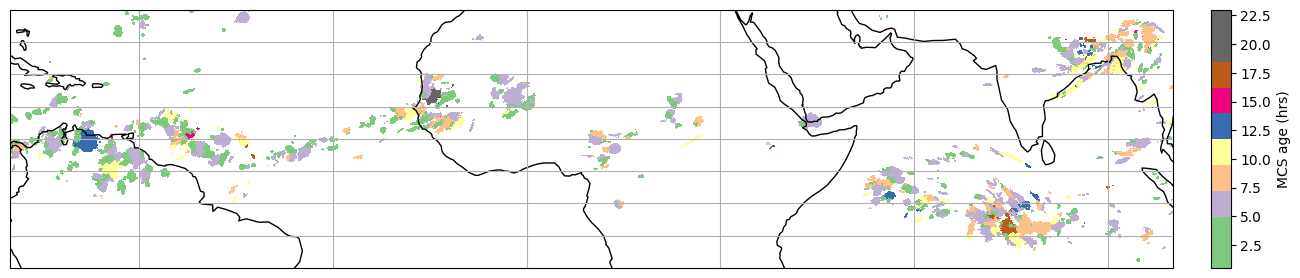

In [42]:
# initialize figure
fig = plt.figure(figsize=(Lx_fig,Ly_fig))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ims = showSnapshot(ax,slice_lat,slice_lon,data=None,segmask=npArray2XrDataArray(age),MCS_color_mode='linear')
    
    showColorBar(fig,ax,ims[0][0],label='MCS age (hrs)')

# test segMaskToAgeMask

In [43]:
from fcns_movie import *

In [80]:
lcm = LifeCycleMapping(None,relation_table,toocan_timetable,toocan)

In [45]:
# example time index
i_t_test = 500

# load segmentation mask for that date
segmask = loadTOOCANSeg(i_t_test,relation_table)[0]

show each side of longitude 0º


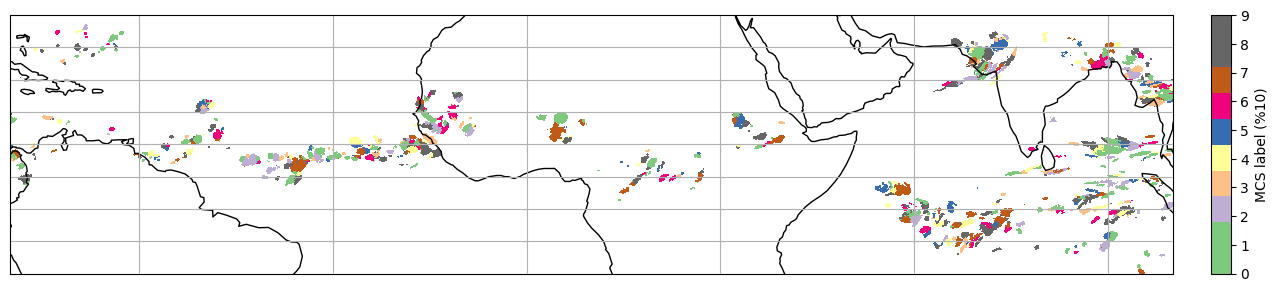

In [46]:
# initialize figure
fig = plt.figure(figsize=(Lx_fig,Ly_fig))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ims = showSnapshot(ax,slice_lat,slice_lon,data=None,segmask=npArray2XrDataArray(segmask.values),MCS_color_mode='cyclic')
    
    showColorBar(fig,ax,ims[0][0],label='MCS label (%10)')

only one side of longitude 0º


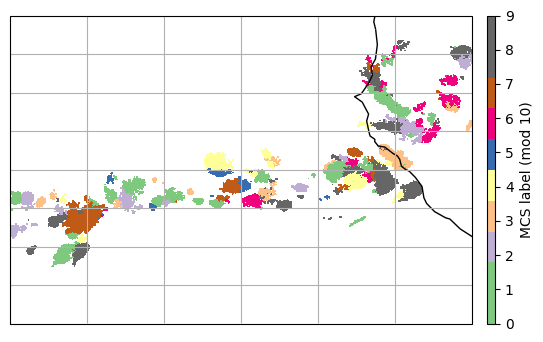

In [47]:
# initialize figure
fig = plt.figure(figsize=(Lx_fig,Ly_fig))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ims = showSnapshot(ax,slice(0,20),slice(320,350),data=None,segmask=npArray2XrDataArray(segmask.values),MCS_color_mode='cyclic')
    
    showColorBar(fig,ax,ims[0][0],label='MCS label (mod 10)')
    
# plt.savefig()

In [87]:
%%time
print('efficient code')
age_mask = lcm.computeAgesFromSegMask(i_t_test,segmask) # EFFICIENT VERSION

efficient code
CPU times: user 54.4 ms, sys: 388 ms, total: 442 ms
Wall time: 446 ms


In [92]:
%%time
print('old code')

# define file to avoid repeating long calculation
age_old_file = 'age_mask_old.pickle'
age_old_path = os.path.join(DIR_DATA,'optimize_and_debug',age_old_file)

overwrite = False
age_file_exists = len(glob.glob(age_old_path)) > 0

# Load or compute
if age_file_exists and not overwrite:
    
    print('load file from disk')
    age_mask_old = pickle.load(open(age_old_path,'rb'))
    
else:
    
    # longer calculation
    # CPU times: user 10min 55s, sys: 3.37 s, total: 10min 58s
    # Wall time: 10min 58s

    print('compute')
    age_mask_old = lcm.computeAgesFromSegMask_old(i_t_test,segmask) # NOT EFFICIENT VERSION # takes 9-10min....
    
    # save
    print('save to disk')
    pickle.dump(age_mask_old,open(age_old_path,'wb'))

old code
compute
2016 labels in current segmentation mask

save to disk
CPU times: user 11min 53s, sys: 5.58 s, total: 11min 59s
Wall time: 11min 59s


In [94]:
# compare results
np.all(np.absolute(age_mask - age_mask_old) < 10)

False

only one side of longitude 0º
only one side of longitude 0º


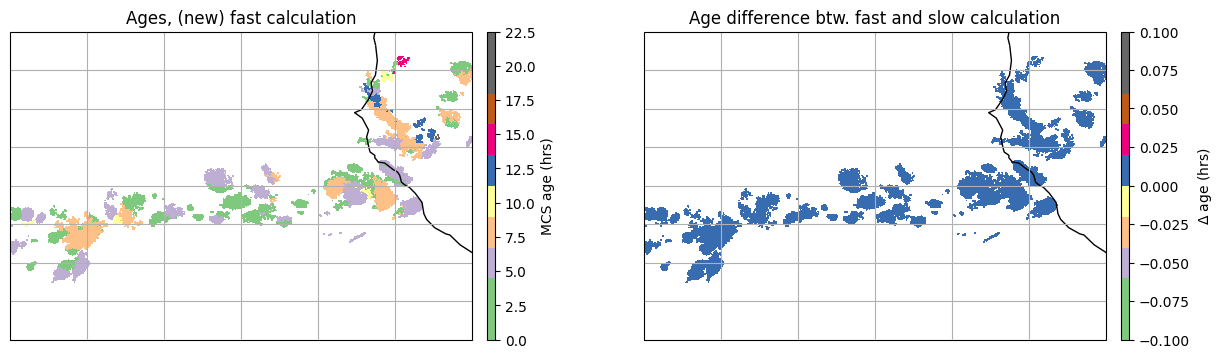

In [97]:
# initialize figure
fig = plt.figure(figsize=(Lx_fig,Ly_fig))
gs = GridSpec(1,2,figure=fig)

ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=0))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    ims = showSnapshot(ax1,slice(0,20),slice(320,350),data=None,segmask=npArray2XrDataArray(age_mask),MCS_color_mode='linear')
    ax1.set_title('Ages, (new) fast calculation')
    showColorBar(fig,ax1,ims[0][0],label='MCS age (hrs)')
    
    ims = showSnapshot(ax2,slice(0,20),slice(320,350),data=None,segmask=npArray2XrDataArray(age_mask_old-age_mask),MCS_color_mode='linear')
    ax2.set_title('Age difference btw. fast and slow calculation')
    showColorBar(fig,ax2,ims[0][0],label=r'$\Delta$ age (hrs)')
    
# plt.savefig(os.path.join(DIR_FIG,'debug/fixed_compare_age_calculations.png'),bbox_inches='tight')

In [52]:
#-- extract label of wrong calculation for this subregion to debug (now calculation is fixed)

s_lon = slice(320,350)
s_lat = slice(0,20)

# convert to xarray
delta_age_mask_xr = npArray2XrDataArray(age_mask_old-age_mask)
age_mask_xr = npArray2XrDataArray(age_mask)
age_mask_old_xr = npArray2XrDataArray(age_mask_old)

# coords
lonarray_toocan,latarray_toocan = getCoords2D(delta_age_mask_xr,s_lon,s_lat) 
# delta age
delta_age_sub = delta_age_mask_xr.sel(longitude=s_lon,latitude=s_lat)[0]
# age
age_sub = age_mask_xr.sel(longitude=s_lon,latitude=s_lat)[0]
age_old_sub = age_mask_old_xr.sel(longitude=s_lon,latitude=s_lat)[0]
# segmask
segmask_sub = segmask.sel(longitude=s_lon,latitude=s_lat)

# mask 
mask_wrong = delta_age_sub > 0

# labels wrong
labels_wrong = np.unique(segmask_sub.values.flatten()[mask_wrong.values.flatten()])
# ages wrong
# ages_wrong = np.unique(age_sub.values.flatten()[mask_wrong.values.flatten()])
ages_wrong = [age_sub.values.flatten()[(segmask_sub == label).values.flatten()][0] for label in labels_wrong]
# ages_old_wrong = np.unique(age_old_sub.values.flatten()[mask_wrong.values.flatten()])
ages_old_wrong = [age_old_sub.values.flatten()[(segmask_sub == label).values.flatten()][0] for label in labels_wrong]

print('MCS with wrong age calculation:',labels_wrong)
print()
print('all time characteristics')
df_wrong = toocan_timetable.take(list((labels_wrong).astype(int)))
df_wrong['ages'] = list(ages_wrong)
df_wrong['ages_old'] = list(ages_old_wrong)
print(df_wrong)


# for label in labels_wrong:
    
    

MCS with wrong age calculation: [128054. 128184. 128227. 129064. 129198. 129204. 130221. 130351. 131391.
 131677. 131739. 132924. 132926. 133800. 134059. 134084.]

all time characteristics
        Unnamed: 0     label  i_t_min  i_t_max  duration  ages  ages_old
128054      128054  128054.0    487.0    513.0      13.5   7.0      11.0
128184      128184  128184.0    487.0    528.0      21.0   7.0      11.0
128227      128227  128227.0    497.0    515.0       9.5   2.0      10.5
129064      129064  129064.0    487.0    515.0      14.5   7.0      11.0
129198      129198  129198.0    497.0    514.0       9.0   2.0      10.5
129204      129204  129204.0    497.0    516.0      10.0   2.0      10.5
130221      130221  130221.0    487.0    509.0      11.5   7.0      11.0
130351      130351  130351.0    497.0    506.0       5.0   2.0      10.5
131391      131391  131391.0    487.0    502.0       8.0   7.0      11.0
131677      131677  131677.0    497.0    517.0      10.5   2.0      10.5
131739  

In [86]:
# DEBUG wrong ages on example MCS
# ERROR was coming from method lcm.timeIndex2Timedelta(self,i_MCS,j_t_MCS)
# at line   " date_30mn = int((str(date_str).split('.')[-1]).ljust(2,'0')) "
# because ljust was omitted (so initial hours were mislabeled 1 instead of 10, 2 instead of 20, etc.
# NOW FIXED

# pick first MCS with a wrong age
label = 128054
df_wrong.loc[label]
i_MCS = lcm.indexOfLabel(label)
MCS = lcm.toocan[i_MCS]

# time characteristics
localtime_Init = MCS.localtime_Init
localtime_End = MCS.localtime_End

# 1. check init times are the same in TOOCAN and relation table
Utime_Init_toocan = lcm.toocan[i_MCS].Utime_Init
print('init Utime in toocan object:',Utime_Init_toocan)
Utime_Init_toocan_2 = lcm.toocan[i_MCS].clusters.Utime[0]
print('init Utime in toocan time object:',Utime_Init_toocan_2)
td_Init_toocan = lcm.timeIndex2Timedelta(i_MCS,0)
print('init timedelta in toocan time object:',td_Init_toocan)

# 2. check index of init time in relation table and corresponding time
i_t_init = np.where(relation_table.UTC == MCS.Utime_Init)[0][0]
time_init_str = relation_table.str_code.loc[i_t_init]
print('init time in relation table occurs at index %d and equals %s'%(i_t_init,time_init_str))


# 3. check index of current time in toocan object
j_t_MCS = np.where(lcm.toocan[i_MCS].clusters.Utime == lcm.relation_table.loc[i_t].UTC)[0][0]
print('current time in toocan object occurs at index %d'%j_t_MCS)
Utime_current_toocan = lcm.toocan[i_MCS].clusters.Utime[j_t_MCS]
print('current time in toocan object:',Utime_current_toocan)
time_current_str = relation_table.str_code.loc[i_t]
print('current time in relation table occurs at index %d and equals %s'%(i_t,time_current_str))
# reltable_t = relation_table.loc[i_t]
# print('current entry in relation table:',reltable_t)

# 4. current timedelta in toocan time object
td_current_toocan = lcm.timeIndex2Timedelta(i_MCS,j_t_MCS)
print('current timedelta in toocan time object:',td_current_toocan)

Utime_toocan = lcm.toocan[i_MCS].clusters.Utime
print('all Utime in toocan object:',Utime_toocan)


# 5. check age calculation in (old method) is fixed
age_t_old = lcm.getAgeMCS(i_t,label)
print('old age calculation:',age_t_old)
age_t_new = (i_t-i_t_init)/2
print('new age calculation:',age_t_new)

#--------------#
# STOPPED HERE #
#--------------#


init Utime in toocan object: 17024.1
init Utime in toocan time object: 17024.1
init timedelta in toocan time object: 17024 days, 5:00:00
init time in relation table occurs at index 487 and equals 2016-8-11-5-0
current time in toocan object occurs at index 13
current time in toocan object: 17024.23
current time in relation table occurs at index 500 and equals 2016-8-11-11-30
current timedelta in toocan time object: 17024 days, 11:30:00
all Utime in toocan object: [17024.1, 17024.11, 17024.12, 17024.13, 17024.14, 17024.15, 17024.16, 17024.17, 17024.18, 17024.19, 17024.2, 17024.21, 17024.22, 17024.23, 17024.24, 17024.25, 17024.26, 17024.27, 17024.28, 17024.29, 17024.3, 17024.31, 17024.32, 17024.33, 17024.34, 17024.35, 17024.36]
old age calculation: 6.5
new age calculation: 6.5


# dev compositeMCSAgeOnDist

In [18]:
##--- Prepare ---##

lcm = LifeCycleMapping(None,relation_table,toocan_timetable,toocan)

# example time index
i_t_test = 500
lat_slice = slice(-30,30)

# load segmentation mask for that date
segmask = loadTOOCANSeg(i_t_test,relation_table)[0].sel(latitude=lat_slice)

# load prec data for that date
pr_t = loadPrec(i_t,relation_table).sel(lat=lat_slice)

# what to compute
metric = 'age'
diag = 'mean'

In [20]:
# load chunked distribution

from casestudy import *

region = 'tropics'
varid = 'Prec'
mask = 'all'

cs = CaseStudy(name='DYAMOND-SAM',
               region=region,
               rel_tab_dyam_seg=loadRelTable('DYAMOND_SEG'))

cs.setSimulationSpecs(i_t_min = 832,
                      i_t_max = 1917)

# where sliced distributions are stored
cs.setDirectories(varid,mask)

# load all distributions
cs.loadDistSliced(varid,mask)

# compute mean precip time series
cs.computeMean(varid='Prec',mask='all')

# find "missing" time indices
cs.findTimeIndToIgnore()

# store times
cs.storeTimes()

# compute full distributions
cs.combineDistributions(varid,mask)

In [21]:
# rename for code dev
dist_var = cs.dist_pr_all
sample = pr_t.values

In [22]:
# 1. compute mask of metric
age_metric = lcm.computeAgesFromSegMask(i_t,segmask,metric).flatten() # 1D array

# 2. digitize sample values in distribution bins
digits = dist_var.getBinIndices(sample) # 1D array
N_dig = np.nanmax(digits)

print('# digits:',N_dig)

# 3. for each bin i, apply diagnostic to the metric and save sample size
diag_all_bins = np.full(N_dig,np.nan)
N_in_bin = np.full(N_dig,np.nan)

# digits: 72


In [23]:
for i_bin in range(0,N_dig):

    # x-y mask in bin i
    mask_bin = (digits == i_bin)
    
    # extract age in bin
    age_in_bin = age_metric[mask_bin]
    
    # apply diagnostic
    if diag in ['mean','max','std','min']:
        diag_in_bin = getattr(np,'nan%s'%diag)(age_in_bin)
        
    diag_all_bins[i_bin] = diag_in_bin
    
    # get bin sample size 
    N_in_bin[i_bin] = age_in_bin.size
    

/tmp/ipykernel_122383/1087238649.py:11: RuntimeWarning: Mean of empty slice
  diag_in_bin = getattr(np,'nan%s'%diag)(age_in_bin)


## test

In [73]:
# rename for code dev
dist_var = cs.dist_pr_all
sample = pr_t.values

diag_all_bins,N_all_bins = lcm.compositeMcsAgeOnDist(i_t,segmask,sample,dist_var,diag='mean',metric='age')

/home/bfildier/analyses/explore-multiscale-extremes/modules/lifecycle_mapping.py:372: RuntimeWarning: Mean of empty slice
  diag_all_bins[i_bin] = getattr(np,'nan%s'%diag)(age_in_bin)


# Dev code DistributionChunked.computeMcsAgeOnDist

In [ ]:
i_t0 = 832
Ni = 5

diag = 'max'

diag_all_bins = [] # store diagnostics vs. bin at each t
N_all_bins = [] # store sample size vs. bin each t
N_valid_all_bins = [] # store sample size of non nan values vs. bin each t

for i_t in range(i_t0,i_t0+Ni):

    print('compute age composite @ i_t = %d ...'%i_t)

    # load segmentation mask for that date
    segmask = loadTOOCANSeg(i_t,lcm.relation_table)[0].sel(latitude=lat_slice).values

    # load prec data for that date
    sample = loadPrec(i_t,lcm.relation_table).sel(lat=lat_slice).values

    diag_all_bins_t,N_all_bins_t,N_valid_all_bins_t = lcm.compositeMcsAgeOnDist(i_t,segmask,sample,dist_var,diag=diag,metric='age')

    # store 
    diag_all_bins.append(diag_all_bins_t)
    N_all_bins.append(N_all_bins_t)
    N_valid_all_bins.append(N_valid_all_bins_t)


In [ ]:
cs

< CaseStudy object:
 . name: DYAMOND-SAM
 . region: tropics
 . model: SAM
 . rel_tab_dyam_seg: <class 'pandas.core.frame.DataFrame'>
 . i_t_min: 832
 . i_t_max: 1917
 . range_t: range(832, 1918)
 . dir_dist_pr_all_sliced: ../results/tropics/Prec/all
 . dict_dist_pr_all_sliced: <class 'dict'>
 . pr_all_mean: [0.08895927 0.09020749 0.09127147 ... 0.0871079  0.08649893 0.08537947]
 . times_to_ignore: <class 'numpy.ndarray'>
 . time: <class 'numpy.ndarray'>
 . dist_pr_all: <class 'conditionalstats_chunked.DistributionChunked'>
 >

In [ ]:
np.vstack(diag_all_bins).shape

(5, 81)

In [ ]:
np.nanmax(np.vstack(diag_all_bins),axis=0)

array([ 0. , 25. , 25. ,  0. ,  0. , 24.5,  0. , 25. , 25. , 25. , 25. ,
       25. , 24.5, 24.5, 24.5, 24.5, 24.5, 24.5, 24.5, 24.5, 24. , 24. ,
       24. , 20. , 24. , 19. , 19.5, 19.5, 19. , 19. , 18.5, 19. , 19. ,
       18.5, 18.5, 19.5, 18.5, 19. , 19. , 18.5, 18.5, 18.5, 18.5, 18.5,
       17. , 18.5, 18.5, 18.5, 17.5, 17. , 18. , 14.5, 14.5, 14.5, 13.5,
       13.5, 14.5, 12.5, 14.5, 14. , 13. , 13.5, 14. , 11. , 13. ,  6. ,
       13. ,  6. , 10.5,  0. ,  6.5, 13. ,  3.5,  0. ,  0. ,  0. ,  3.5,
        0. ,  0. ,  6. ,  0. ])

In [ ]:
cs.dist_pr_all

< DistributionChunked object:
 . bintype: invlogQ
 . nbins: 81
 . nbpd: 10
 . nppb: 4
 . nd: 8
 . fill_last_decade: False
 . name: pr, all, DYAMOND-SAM tropics, all times
 . size: 15238250496
 . vmin: -0.075976014
 . vmax: 125.83331
 . rank_edges: <class 'numpy.ndarray'>
 . ranks: <class 'numpy.ndarray'>
 . percentiles: <class 'numpy.ndarray'>
 . bins: <class 'numpy.ndarray'>
 . density: None
 . bin_locations_stored: [False False False ... False False False]
 . overwrite: False
 . dist_chunks: <class 'list'>
 . chunks_to_ignore: <class 'list'>
 . nchunks: 1086
 . size_chunks: <class 'list'>
 . vmin_chunks: <class 'list'>
 . vmax_chunks: <class 'list'>
 . bin_locations: {}
 >

# dev caseStudy combineMcsAgeDiagnostics

In [11]:
# Load case study

def loadCaseStudy(varid,region,mask):
    
    varid_str = varid
    if varid == 'Prec':
        varid_str = 'pr'
    # output dir
    dir_in = os.path.join(DIR_OUT,region,varid,mask)
    # save
    cs = pickle.load(open(os.path.join(dir_in,'case_study.pickle'),'rb'))
    # output
    return cs

In [26]:
varid = 'Prec'
region = 'tropics'
mask = 'all'

# parameters to set
#------------------
mask_xy = 'ocean'
# mask_xy = 'land'
# mask_xy='allXY'
#------------------
# mask_T = 'min5hr'
mask_T = 'min10hr'
# mask_T = 'allT'
#------------------
metric = 'norm_age'
# metric = 'age'
diag = 'mean'

# dependent variables
#------------------
# name of diagnostic
diag_name = '%s_%s_%s_%s'%(diag,metric,mask_xy,mask_T)
print('diag name:',diag_name)
# where to fetch data
save_dir = os.path.join(DIR_OUT,region,diag_name,mask,'time_slices')
print('merge data from:',save_dir)

In [58]:
# 2. load diagnostic and sample sizes (TO DO maybe: in all distributions at t)

def loadDiagnostics(cs,diag_name):
    
    # where to fetch data
    save_dir = os.path.join(DIR_OUT,region,diag_name,mask,'time_slices')
    
    cs.diag_all_t = []
    cs.N_all_t = []
    cs.N_valid_all_t = []

    for i_t in cs.range_t:

        if i_t%100 == 0 or i_t in [cs.i_t_min, cs.i_t_max]:
            print(i_t,end='..')

        # load
        cs.diag_all_t.append(pickle.load(open(os.path.join(save_dir,'%s_t_%d.pickle'%(diag_name,i_t)),'rb')))
        cs.N_all_t.append(pickle.load(open(os.path.join(save_dir,'N_all_bins_t_%d.pickle'%(i_t)),'rb')))
        cs.N_valid_all_t.append(pickle.load(open(os.path.join(save_dir,'N_valid_all_bins_t_%d.pickle'%(i_t)),'rb')))

    print()

In [49]:
# 3. combine diagnostics from all times in cs.dist_var (DistributionChunked)

def combineMcsAgeDiagnostic(cs,diag,metric):
    
    # # name of diagnostic
    # diag_name = '%s_%s'%(diag,metric)
    N_t = len(cs.N_all_t)
    N_Q = cs.dist_pr_all.nbins
    
    if diag == 'mean':
        
        N_valid = np.full(N_Q,0)
        diag_value = np.full(N_Q,0)
        
        for i_t in range(N_t):

            if cs.diag_all_t[i_t] is not None: # None should correspond to indices with corrupted data
                
                N_valid = N_valid + cs.N_valid_all_t[i_t]
                diag_value = diag_value + (cs.N_valid_all_t[i_t])*(cs.diag_all_t[i_t])
        
        # normalize sum by total number of valid points in each bin
        diag_value = diag_value/N_valid
        
    return diag_value, N_valid

In [38]:
# 4. clean slice to plot

def hideFirstBins(i_min,var_age,N_valid):
    # start after last nan value
    # i_min = np.where(np.isnan(mean_norm_age))[0][-1]
    # define slice
    s_hide = slice(None,i_min)
    # hide noisy/nan beginning
    var_age[s_hide] = np.nan
    N_valid[s_hide] = np.nan
    
    return var_age,N_valid

832..900..1000..1100..1200..1300..1400..1500..1600..1700..1800..1900..1917..


/tmp/ipykernel_3237028/3590186172.py:23: RuntimeWarning: invalid value encountered in true_divide
  diag_value = diag_value/N_valid


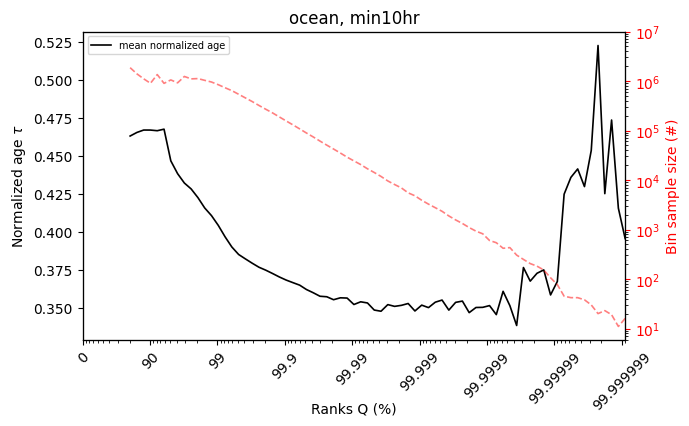

In [51]:
fig,ax = plt.subplots(figsize=(7,4))

ax_N = ax.twinx()

rankmax = 99.999999
ranks = cs.dist_pr_all.ranks

# frame
setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

# 1. load case study
cs = loadCaseStudy(varid,region,mask)

# 2. load diagnostics/sample size
loadDiagnostics(cs,diag_name)

# 3. compute/combine age
var_age, N_valid = combineMcsAgeDiagnostic(cs,'mean',metric)

# 4. hide first bins
var_age,N_valid = hideFirstBins(7,var_age,N_valid)

# Manual
showData(ax,ranks,var_age,color='k',linewidth=1.2,alpha=1,rankmin=0,rankmax=rankmax,label='mean normalized age')

# embedded method DistributionChunked.computeDistribution
showData(ax_N,ranks,N_valid,color='r',linestyle='--',linewidth=1.2,alpha=0.5,rankmin=0,rankmax=rankmax,label='sample size')


#- labels
ax.set_xlabel('Ranks Q (%)',labelpad=45)
ax.set_ylabel(r'Normalized MCS age $\tau$')
ax.legend(fontsize=7)

ax.set_ylabel(r'Normalized age $\tau$')
ax_N.set_ylabel('Bin sample size (#)')
ax.set_title('%s, %s'%(mask_xy,mask_T))

ax_N.set_yscale('log')
ax_N.yaxis.label.set_color('red')
ax_N.tick_params(axis='y', colors='red')

#- bounds
# ax.set_ylim((0.2,0.55))
ax_N.set_ylim((6,1e7))


plt.savefig(os.path.join(DIR_FIG,'lifecycle','%s_and_N_vs_ranks.pdf'%diag_name),bbox_inches='tight')
plt.show()

832..900..1000..1100..1200..1300..1400..1500..1600..1700..1800..1900..1917..
832..

/tmp/ipykernel_3237028/3590186172.py:23: RuntimeWarning: invalid value encountered in true_divide
  diag_value = diag_value/N_valid


900..1000..1100..1200..1300..1400..1500..1600..1700..1800..1900..1917..


/tmp/ipykernel_3237028/3590186172.py:23: RuntimeWarning: invalid value encountered in true_divide
  diag_value = diag_value/N_valid


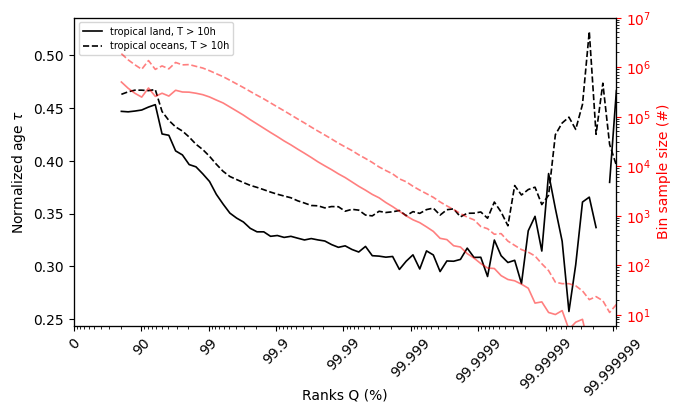

In [67]:
# Several curves on same graph

mask_xy_T_all = 'land_min10hr', 'ocean_min10hr'
labels = 'tropical land, T > 10h', 'tropical oceans, T > 10h'
linestyles = '-','--'

fig,ax = plt.subplots(figsize=(7,4))

ax_N = ax.twinx()

rankmax = 99.999999
ranks = cs.dist_pr_all.ranks

# frame
setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

for mask_xy_T,label,ls in zip(mask_xy_T_all,labels,linestyles):
    
    diag_name = 'mean_%s_%s'%(metric,mask_xy_T)

    # 1. load case study
    cs = loadCaseStudy(varid,region,mask)

    # 2. load diagnostics/sample size
    loadDiagnostics(cs,diag_name)

    # 3. compute/combine age
    var_age, N_valid = combineMcsAgeDiagnostic(cs,'mean',metric)

    # 4. hide first bins
    var_age,N_valid = hideFirstBins(7,var_age,N_valid)

    # Manual
    showData(ax,ranks,var_age,color='k',linestyle=ls,linewidth=1.2,alpha=1,rankmin=0,rankmax=rankmax,label=label)

    # if diag_name == diag_names[0]:
        
    # embedded method DistributionChunked.computeDistribution
    showData(ax_N,ranks,N_valid,color='r',linestyle=ls,linewidth=1.2,alpha=0.5,rankmin=0,rankmax=rankmax,label='sample size')


#- labels
ax.set_xlabel('Ranks Q (%)',labelpad=45)
ax.set_ylabel(r'Normalized MCS age $\tau$')
ax.legend(fontsize=7)

ax.set_ylabel(r'Normalized age $\tau$')
ax_N.set_ylabel('Bin sample size (#)')
# ax.set_title('Systems)

ax_N.set_yscale('log')
ax_N.yaxis.label.set_color('red')
ax_N.tick_params(axis='y', colors='red')

#- bounds
# ax.set_ylim((0.2,0.55))
ax_N.set_ylim((6,1e7))


plt.savefig(os.path.join(DIR_FIG,'lifecycle','norm_age_and_N_vs_ranks_landmin10hr_oceanmin10hr.pdf'),bbox_inches='tight')
plt.show()

832..900..1000..1100..1200..1300..1400..1500..1600..1700..1800..1900..1917..


/tmp/ipykernel_3237028/3590186172.py:23: RuntimeWarning: invalid value encountered in true_divide
  diag_value = diag_value/N_valid


832..900..1000..1100..1200..1300..1400..1500..1600..1700..1800..1900..1917..


/tmp/ipykernel_3237028/3590186172.py:23: RuntimeWarning: invalid value encountered in true_divide
  diag_value = diag_value/N_valid


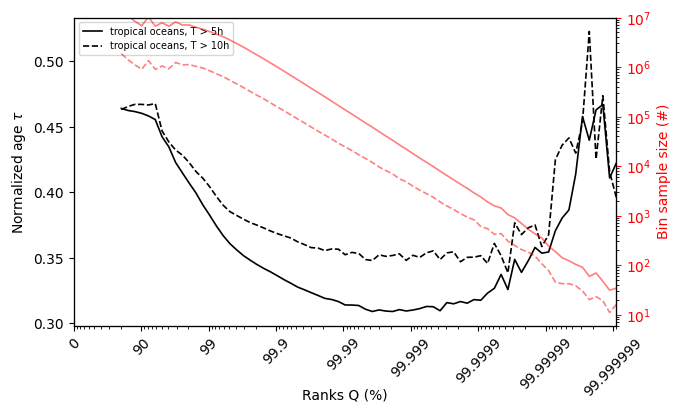

In [68]:
# Several curves on same graph

mask_xy_T_all = 'ocean_min5hr', 'ocean_min10hr'
labels = 'tropical oceans, T > 5h', 'tropical oceans, T > 10h'
linestyles = '-','--'

fig,ax = plt.subplots(figsize=(7,4))

ax_N = ax.twinx()

rankmax = 99.999999
ranks = cs.dist_pr_all.ranks

# frame
setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

for mask_xy_T,label,ls in zip(mask_xy_T_all,labels,linestyles):
    
    diag_name = 'mean_%s_%s'%(metric,mask_xy_T)

    # 1. load case study
    cs = loadCaseStudy(varid,region,mask)

    # 2. load diagnostics/sample size
    loadDiagnostics(cs,diag_name)

    # 3. compute/combine age
    var_age, N_valid = combineMcsAgeDiagnostic(cs,'mean',metric)

    # 4. hide first bins
    var_age,N_valid = hideFirstBins(7,var_age,N_valid)

    # Manual
    showData(ax,ranks,var_age,color='k',linestyle=ls,linewidth=1.2,alpha=1,rankmin=0,rankmax=rankmax,label=label)

    # if diag_name == diag_names[0]:
        
    # embedded method DistributionChunked.computeDistribution
    showData(ax_N,ranks,N_valid,color='r',linestyle=ls,linewidth=1.2,alpha=0.5,rankmin=0,rankmax=rankmax,label='sample size')


#- labels
ax.set_xlabel('Ranks Q (%)',labelpad=45)
ax.set_ylabel(r'Normalized MCS age $\tau$')
ax.legend(fontsize=7)

ax.set_ylabel(r'Normalized age $\tau$')
ax_N.set_ylabel('Bin sample size (#)')
# ax.set_title('Systems)

ax_N.set_yscale('log')
ax_N.yaxis.label.set_color('red')
ax_N.tick_params(axis='y', colors='red')

#- bounds
# ax.set_ylim((0.2,0.55))
ax_N.set_ylim((6,1e7))


plt.savefig(os.path.join(DIR_FIG,'lifecycle','norm_age_and_N_vs_ranks_oceanmin5hr_oceanmin10hr.pdf'),bbox_inches='tight')
plt.show()

# Dev masks

## Geographical masks

Land-ocean

In [35]:
landfile = 'DYAMOND_9216x4608x74_7.5s_4km_4608_0000200160.LANDMASK.2D.nc'
landpath = os.path.join(DIR_DYAMOND,landfile)

landmask = xr.open_dataarray(landpath).sel(lat=slice(-30,30))[0]

In [36]:
landmask

<xarray.DataArray 'LANDMASK' (lat: 1554, lon: 9216)>
[14321664 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -30.0 -29.96 -29.92 -29.88 ... 29.88 29.92 29.96 30.0
  * lon      (lon) float32 0.01953 0.05859 0.09766 0.1367 ... 359.9 359.9 360.0
    time     float32 231.4
Attributes:
    long_name:  Landmask:0-ocean,1-land,2-landice,3-seaice
    units:

In [38]:
island = landmask > 0.5
isocean = landmask < 0.5
Nland = np.sum(island).values
Nocean = np.sum(isocean).values
Ntot = np.size(island)
print('fraction of land points =',Nland/Ntot)
print('fraction of ocean points =',Nocean/Ntot)

fraction of land points = 0.2583796128718004
fraction of ocean points = 0.7416203871281997
